# Funtional Image Processing in Rust - Part 1
This notebook provides an interactive version of the code feature in the [Functional Image Processing in Rust - Part 1 blog post](https://keithschulze.com/functional-img-rust/). This is a [Jupyter notebook](https://jupyter-notebook.readthedocs.io) and you can find out more about how to interact with the notebook [here](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#basic-workflow).

If you execute (i.e., Shift + Enter) all the cells in order from top to bottom, it should produce the images featured in the blog post.

In [18]:
:dep image = "0.25.8"
:dep base64 = "0.22.1"
:dep num = "0.4.3"

In [3]:
use image::ImageBuffer;
use image::Luma;
use num::Integer;

In [6]:
// Note: This cell just provides some functions that allow image types 
// from PistonDevelopers `image` to be rendered inline in a Jupyter notebook.
// Essentially allows us to call `.show()` on an ImageBuffer to show it inline.

use image::ImageEncoder;

pub trait Showable {
    fn show(&self);
}

impl Showable for image::RgbImage {
    fn show(&self) {
        let mut buffer = Vec::new();
        image::codecs::png::PngEncoder::new(&mut buffer)
            .write_image(&**self, self.width(), self.height(), image::ColorType::Rgb8.into())
            .unwrap();
        let img = base64::encode(&buffer);
        println!("EVCXR_BEGIN_CONTENT image/png\n{}\nEVCXR_END_CONTENT", img);
    }
}

impl Showable for image::RgbaImage {
    fn show(&self) {
        let mut buffer = Vec::new();
        image::codecs::png::PngEncoder::new(&mut buffer)
            .write_image(
                &**self,
                self.width(),
                self.height(),
                image::ColorType::Rgba8.into(),
            )
            .unwrap();
        let img = base64::encode(&buffer);
        println!("EVCXR_BEGIN_CONTENT image/png\n{}\nEVCXR_END_CONTENT", img);
    }
}

impl Showable for image::GrayImage {
    fn show(&self) {
        let mut buffer = Vec::new();
        image::codecs::png::PngEncoder::new(&mut buffer)
            .write_image(&**self, self.width(), self.height(), image::ColorType::L8.into())
            .unwrap();
        let img = base64::encode(&buffer);
        println!("EVCXR_BEGIN_CONTENT image/png\n{}\nEVCXR_END_CONTENT", img);
    }
}

In [7]:
pub type Coord = (f32, f32);

pub trait Img<A> : Fn(Coord) -> A {}
impl <F, A> Img<A> for F where F: Fn(Coord) -> A {}

In [8]:
pub trait Region : Img<bool> {}
impl <F> Region for F where F: Fn(Coord) -> bool {}

In [9]:
pub type Vector = (f32, f32);

pub fn render<F: Region>(
    im: F,
    width: u32,
    height: u32,
    origin: Vector,
    pixel_size: Vector,
) -> ImageBuffer<Luma<u8>, Vec<u8>> {
    let (pw, ph) = pixel_size;
    let (ox, oy) = origin;
    image::ImageBuffer::from_fn(width, height, |x, y| {
        let pixel = im((x as f32 * pw - ox, y as f32 * ph - oy)) as u8;
        image::Luma([pixel * 255])
    })
}


In [10]:
pub fn vstrip() -> impl Region {
    |(x, _y): Coord| x.abs() <= 0.5
}

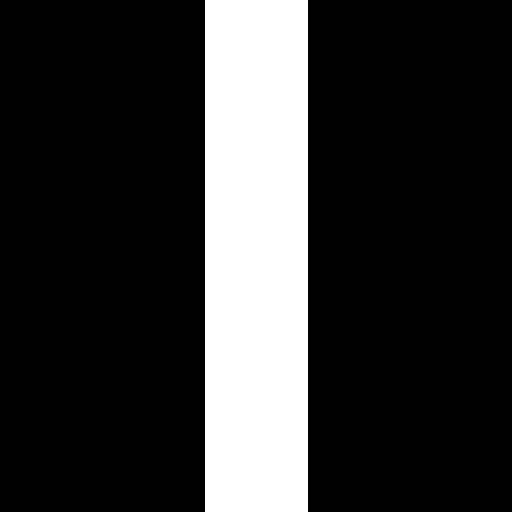

In [11]:
render(vstrip(), 512, 512, (2.5, 0.0), (0.009765625, 0.009765625)).show()

In [12]:
pub fn checker() -> impl Region {
    |(x, y): Coord| ((x.floor() + y.floor()) as u32).is_even()
}

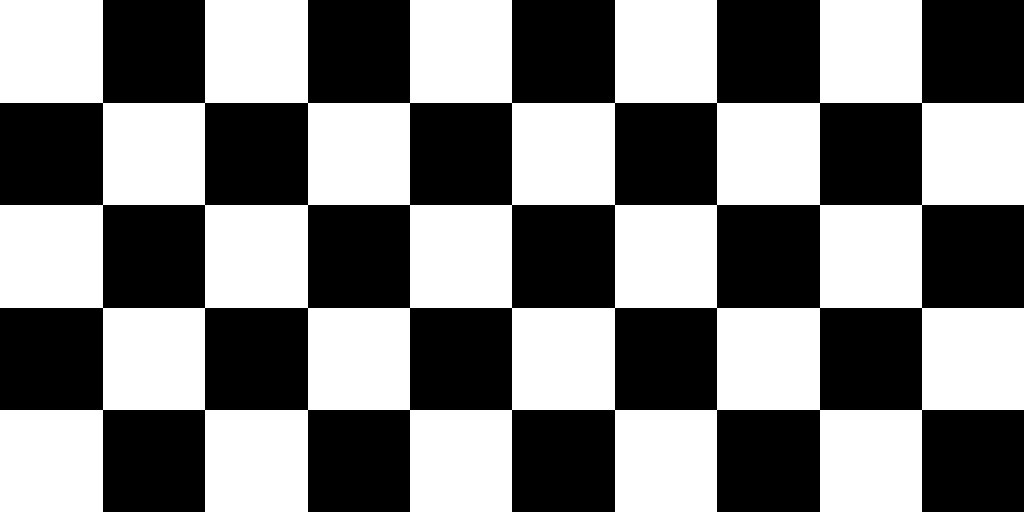

In [13]:
render(checker(), 1024, 512, (0.0, 0.0), (0.009765625, 0.009765625)).show()

In [14]:
pub fn dist_o(c: Coord) -> f32 {
    let (x, y) = c;
    (x * x + y * y).sqrt()
}

pub fn alt_rings() -> impl Region {
    |p| (dist_o(p).floor() as i32).is_even()
}

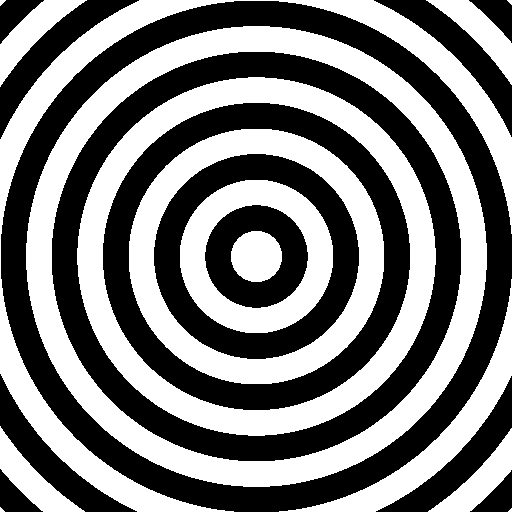

In [15]:
render(alt_rings(), 512, 512, (10.0, 10.0), (0.0390625, 0.0390625)).show()

In [16]:
use std::f32::consts::PI;

pub type Polar = (f32, f32);

pub fn to_polar(c: Coord) -> Polar {
    let (x, y) = c;
    (dist_o(c), y.atan2(x))
}

pub fn from_polar(polar: Polar) -> Coord {
    let (p, theta) = polar;
    (p * theta.cos(), p * theta.sin())
}

pub fn compose<A, B, C, F, G>(f: F, g: G) -> impl Fn(A) -> C
where
    F: Fn(B) -> C,
    G: Fn(A) -> B,
{
    move |x| f(g(x))
}

pub fn polar_checker(n: i32) -> impl Region {
    let sc = move |polar: Polar| -> Polar {
        let (p, theta) = polar;
        (p, theta * (n as f32 / PI))
    };
    compose(checker(), compose(sc, to_polar))
}

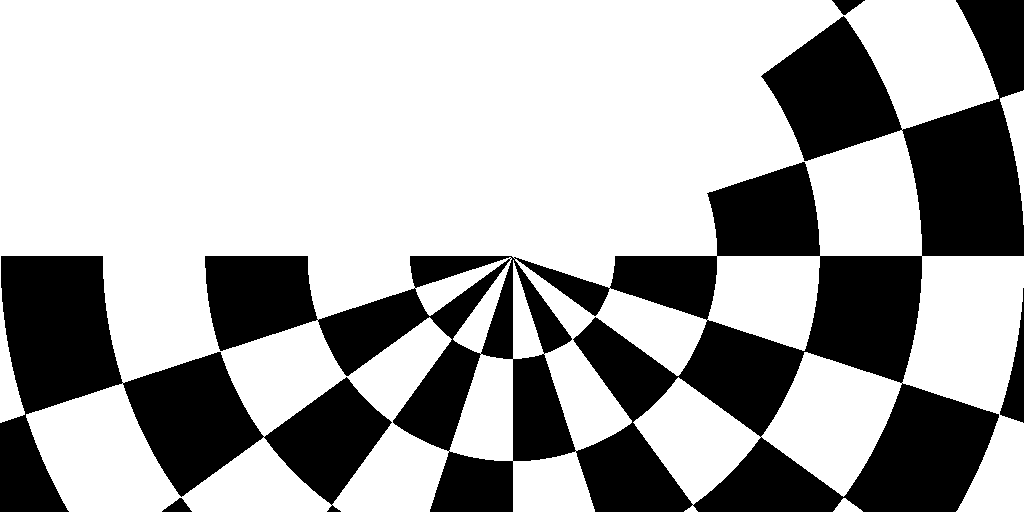

In [17]:
render(polar_checker(10), 1024, 512, (5.0, 2.5), (0.009765625, 0.009765625)).show()